# WL climatology for lat-min at -70

## Inputs

In [1]:
# Monthly data and temporal variability

#model
expt    = '01deg_jra55v140_iaf'
model   = 'access-om2-01'
var1 = 'aice_m'
var2 = 'temp'
var3 = 'salt'
var4 = 'pot_rho_0'

#time domain
yrst    = 1985 #1985
yren    = 2015
#start and end times
st = str(yrst)+'-01-02'   #ACCESS OM dates are at 00:00Z, so a start date of 1st Jan would give you December of prev year
en = str(yren)+'-12-30'

#Common latitude and depth range

# Latitude between 85 S and 55 S [85 S range for Weddell and Ross Gyre]
latmin  = -75. # TESTING 75 S      # in the previous code it was -70
latmax  = -50.

# Depth [Upper 300m]
zmin    = 0.
zmax    = 500      #250  #400.

# Set the longitude range for each sector in a list to read it in easier
kh   =  [-15, 70, -55]         # 345,  70  # King Haakon
ea   =  [70, -210, -57]        #  70 ,150  # East Antarctic
rs   =  [-210, -135, -62]      # 150, 250  # Ross Sea
am   =  [-135, -90, -63]       # 250, 290  # Amundsen sea
bs   =  [-90, -60, -60]                    # Bellingshausen sea
wl   =  [-60, -15, -58]        # 290, 345  # Weddell sea

sectors = [kh, ea, rs, am, bs, wl]

# winter ice extent and northern latitude bound for kh, ea, ra, ab, wl
winter_sie = [55, 57, 62, 63, 58]

# Put sector names in a list for plot titles

sNam    = ['King Haakon', 'East Antarctic', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea']
sNam2   = ['KH', 'EA', 'RS', 'AM', 'BS', 'WL']

## Imports

In [2]:
#plot destination
%matplotlib inline

#set up session

import cosima_cookbook as cc

import IPython.display
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker


import numpy as np
import xarray as xr
import cmocean as cm
import pandas as pd
import cartopy.crs as crs
import scipy.stats
import scipy.signal
import dask.array

#connect to database
session = cc.database.create_session(db='/g/data/ik11/databases/cosima_master.db')
#db='/g/data/ik11/databases/cosima_master.db'
#db='/g/data/hh5/tmp/cosima/database/access-om2.db'

from dask.distributed import Client
cl=Client(n_workers=4)
cl

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33283,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://10.6.121.14:35737,Total threads: 2
Dashboard: /proxy/38095/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:46107,


## Loading data

MLD

In [4]:
#Slice ocean variables while loading Depth range and to Southern Hemisphere

#Since we are loading the climatologies of T, S, and Rho we dont need to load this again, but we need to load MLD 

#2 Temperature 
OM_temp = cc.querying.getvar(expt,var2,session,start_time=st,end_time=en, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc').sel(yt_ocean= slice(latmin, latmax), st_ocean= slice(zmin, zmax))

atr = OM_temp.attrs
OM_temp = OM_temp-273.15 # Convert Kelvin to Celcius  # This calculation also removed the attributes from the array, so we fix that
OM_temp.attrs = atr
#OM_temp.coords   # Print the loaded file to check for year ranges etc

#3 Salt
OM_salt = cc.querying.getvar(expt,var3,session,start_time=st,end_time=en, ncfile='ocean-3d-salt-1-monthly-mean-ym_%.nc' ).sel(yt_ocean= slice(latmin, latmax), st_ocean= slice(zmin, zmax))
OM_salt.data

#4 Density
OM_rho = cc.querying.getvar(expt,var4,session,start_time=st,end_time=en).sel(yt_ocean= slice(latmin, latmax), st_ocean= slice(zmin, zmax))

%time

#

OM_mld = cc.querying.getvar(expt,'mld',session,start_time=st,end_time=en, ncfile='ocean-2d-mld-1-monthly-mean-ym_%.nc' ).sel(yt_ocean= slice(latmin, latmax))

# Area
A = cc.querying.getvar(expt,'area_t',session, n=1)

#OM_temp.coords   # Print the loaded file to check for year ranges etc

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


### Functions to calculate WEIGHTED sector average from raw T, S, Rho and mld data

In [3]:
def sector_mean(data, area, region):
    """
    Create spatially averaged dataarray for the
    data: Temperature or salinity dataset
            OM_temp, OM_salt
    region: Sea ice sectors
            kh, ea, ra, ab, wl"""
    
    # Step one: slice to latitude ranges
    
    region_slice = data.sel(yt_ocean=slice(latmin, region[2]))
    area_slice   = area.sel(yt_ocean=slice(latmin, region[2]))
    
    # Step two: create the weighted dataset
    region_weighted = region_slice.weighted(area_slice.fillna(0)).mean('yt_ocean')
    
    # Step three: do the longitudinal selection and average
    
    
    # Region slice
    if region[0]>region[1]:
        region_slice=region_weighted.isel(xt_ocean = ( data.xt_ocean > region[0] ) | (data.xt_ocean < region[1]) )
        region_slice=region_slice.sel( st_ocean=slice(zmin, zmax))
    else:
        region_slice=region_weighted.sel(xt_ocean=slice(region[0],region[1]), st_ocean=slice(zmin, zmax))
        
          
    spatial_mean=region_slice.mean('xt_ocean')
   
    
    return spatial_mean




def mld_sector_mean(data, area, region):
    """
    Create spatially averaged dataarray for the
    data: Temperature or salinity dataset
            OM_temp, OM_salt
    region: Sea ice sectors
            kh, ea, ra, ab, wl"""
    
    # Step one: slice to latitude ranges
    
    region_slice = data.sel(yt_ocean=slice(latmin, region[2]))
    area_slice   = area.sel(yt_ocean=slice(latmin, region[2]))
    
    # Step two: create the weighted dataset
    region_weighted = region_slice.weighted(area_slice.fillna(0)).mean('yt_ocean')
    
    # Step three: do the longitudinal selection and average    
    
    if region[0]>region[1]:
        region_slice=region_weighted.isel(xt_ocean = ( data.xt_ocean > region[0] ) | (data.xt_ocean < region[1]) )
    else:
        region_slice=region_weighted.sel(xt_ocean=slice(region[0],region[1]))
             
        
    spatial_mean=region_slice.mean('xt_ocean')
   
    
    return spatial_mean

# Function to get the dT/dz max to overlay on plot

def dTdz_max_depth(dTdz_dat, dummy_dat):
    
    ''' Input dTdz data (numpy array) along with respective sector climatology array
        or any other array with similar dimension to get the metadata and depth values   
    '''
    
    s_dat2 = dTdz_dat[1,...]                
    s_dat = dummy_dat                

    # Get the max and min from the dT/dz and dS/dz
    ## # Need the min value only when it is negative and need the max for all months
    
    min_t = np.argmin(s_dat2, axis=1) # These give the index along the depth axis where the max of min values are encountered
    max_t = np.argmax(s_dat2, axis=1)

    # For now, let's only work with the dT/dz min
    
    # Empty list for dT/dz max and min values
    dT_dz_max = []
    # dT_dz_min = []
    
    # Empty list for depth at which the values occur
    #dz_min = []
    dz_max = []
    
    # Access and append the values and depth in loop
    for i in range (len(max_t)):  # Range 12 or according to length of the input data

        # get the values of dT/dz and dS/dz
        val = s_dat.values
     #   val_min = val[i, min_t[i]]
        val_max = val[i, max_t[i]]
      #  dT_dz_min.append(val_min)
        dT_dz_max.append(val_max)

        # get the depth
        depth = s_dat.st_ocean.values 
       # d_min = depth[min_t[i]]
        d_max = depth[max_t[i]]
        #dz_min.append(d_min)
        dz_max.append(d_max)

    # Create the 24 indice dat for plotting 

    max_depth = dz_max
    #max_depth.extend(dz_max)
    dummy=dz_max
    max_depth.extend(dummy)
    max_val = dT_dz_max
    max_val.extend(max_val)

    dTdz_returns = [dz_max, dT_dz_max]
#     print(shape(max_depth)
    
    return max_depth
# to test: tt1 = dTdz_max_depth(kh_dTdz,  kh_Tc)


## Plotting

plotting functions

In [4]:
def temp_climatology_plot_WL (data, data_dTdz, data_dDdz, data_mld):
    
    # colormap, levels 
    
#     lev = np.arange(-2,1.5,0.1)
#     cont_lev = [-1.5, 0 ]  #np.arange(-1.5, 1.5, 0.5)
    
    lev = np.arange(-1.8,1.2,0.1)
    cont_lev = [-1.5, 0 ]  #np.arange(-1.5, 1.5, 0.5)
    
    
    colmap = cm.cm.thermal    #'bwr'   
    xlabels2=['J','F','M','A','M','J','J','A','S','O','N','D']
    x=list(range(12))
    
    ax = plt.gca()
    
    # Plotting
    # countour fill
    p = plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, extend='max')
    
    # Contour - thick + labels
    cont1=plt.contour(x, data.st_ocean, data.transpose(), levels=[-1.5],   colors='darkgrey', linewidths=0.5) # linewidth = 1; default
    cont2=plt.contour(x, data.st_ocean, data.transpose(), levels=[-0.5],   colors='lightgrey', linewidths=0.75) # linewidth = 1; default
    cont3=plt.contour(x, data.st_ocean, data.transpose(), levels=[0.0],   colors='k', linewidths=0.75, alpha=0.5) # linewidth = 1; default
    
    
    c_lab = ax.clabel(cont1, fmt='%1.1f', colors='lightgrey', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
    
    c_lab = ax.clabel(cont3, fmt='%1.1f', colors='k', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
    
    
    
#     c_lab = ax.clabel(cont, fmt='%1.2f', colors='black', fontsize=12)
#     c_lab.set_alpha(.4)
    
    plt.gca().invert_yaxis()
    #plt.colorbar(mappable = p)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(xlabels2,fontsize=10)
    
    # dT/dz
    tt1 = dTdz_max_depth(data_dTdz,  data)
    tt1 = tt1[0:12]
    plt.plot(x, tt1, color='k', lw=2)
    
    # dRho/dz
    tt2 = dTdz_max_depth(data_dDdz,  data)
    tt2 = tt2[0:12]
    plt.plot(x, tt2, color='lightgrey', lw=1.5, alpha=0.7)
    plt.plot(x, tt2, color='k', lw=1.5, ls='--') #'teal'

    
    # MLD
    plt.plot(data_mld, color='r' )
    
#     plt.colorbar(p)


    
def salt_climatology_plot_WL (data, data_dTdz, data_dDdz, data_mld):
    
    # colormap, levels 
    
#     lev = np.arange(33,35,0.1)
#     cont_lev = [33.5, 34, 34.5]    #np.arange(33, 35, 0.25)
#     cont_lev2 = np.arange(33.5, 34.5, 0.1)
    
    lev = np.arange(33.5,34.5,0.05)
    cont_lev = [ 34, 34.5]    #np.arange(33, 35, 0.25)
    cont_lev2 = np.arange(33.5, 34.5, 0.1)
    
    colmap = cm.cm.haline  # cm.cm.matter         #'gnuplot_r'     #'jet'  #cm.cm.haline, ice, matter
    xlabels2=['J','F','M','A','M','J','J','A','S','O','N','D']
    x=list(range(12))
    
    ax = plt.gca()
    
    # Plotting
    # countour fill
    p = plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, extend='both')
    
    # Contour - thick + labels
    cont=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev,   colors='darkgrey', linewidths=0.5) # linewidth = 1; default
    cont2=plt.contour(x, data.st_ocean, data.transpose(), levels=[33.5],   colors='lightgrey', linewidths=0.75) # linewidth = 1; default
    

    
    c_lab = ax.clabel(cont, fmt='%1.1f', colors='black', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
    
    c_lab = ax.clabel(cont2, fmt='%1.1f', colors='lightgrey', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
    
    
    plt.gca().invert_yaxis()
    #plt.colorbar(mappable = p)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(xlabels2,fontsize=10)
    
    # dT/dz
    tt1 = dTdz_max_depth(data_dTdz,  data)
    tt1 = tt1[0:12]
    plt.plot(x, tt1, color='k', lw=2)
    
    # dRho/dz
    tt2 = dTdz_max_depth(data_dDdz,  data)
    tt2 = tt2[0:12]
    plt.plot(x, tt2, color='lightgrey', lw=1.5, alpha=0.7)
    plt.plot(x, tt2, color='k', lw=1.5, ls='--') #'teal'

    
    # MLD
    plt.plot(data_mld, color='r', lw=1.5 ) 
    
#     plt.colorbar(p)

 
    
 
    
def dTdz_climatology_plot_WL (data, data_dTdz, data_dDdz, data_mld):
    # Use dTdz_1 set for data
    data = data*10

#     from matplotlib import colors
#     divnorm=colors.TwoSlopeNorm(vmin=-0.6, vcenter=0., vmax=0.5)
    
    #colormap, levels 
    mnlev = -0.4
    mxlev = 0.3
    nlev = 10
    lev = np.arange(mnlev, mxlev, mxlev/nlev)
    cont_lev = [ 0.075, 0.25]   
    cont_lev2 = [-0.01]
    
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vmin=mnlev, vcenter=0., vmax=mxlev)
    
    
    
    #[ -0.2, 0, 0.2]
    
#     lev = np.arange(-0.1, 0.5, 0.02)
#     cont_lev = [ 0.075, 0.25]   
#     cont_lev2 = [-0.1]#[ -0.2, 0, 0.2]
    
    colmap = cm.cm.balance           #'gnuplot_r'     #'jet'  #cm.cm.haline, ice, matter
    xlabels2=['J','F','M','A','M','J','J','A','S','O','N','D']
    x=list(range(12))
    
    ax = plt.gca()
    
    # Plotting
    # countour fill
    p = plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, extend='both', norm=divnorm)
    
    # Contour - thick + labels
    cont=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev,   colors='w', linewidths=1) # linewidth = 1; default

    cont2=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev2,   colors='lightgrey', linewidths=1.25) # linewidth = 1; default

    dTdz_cont3 = plt.contour( x, data.st_ocean, data.transpose(), colors='w', levels = [0.19], linewidths=1.5 ) #0.20 ***

    
    c_lab = ax.clabel(cont, fmt='%1.2f', colors='black', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
   
    c_lab2 = ax.clabel(cont2, fmt='%1.2f', colors='black', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab2] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
    
    
    plt.gca().invert_yaxis()
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(xlabels2,fontsize=10)
    
    # dT/dz
    tt1 = dTdz_max_depth(data_dTdz,  data)
    tt1 = tt1[0:12]
    plt.plot(x, tt1, color='k', lw=2)
    
    # dRho/dz
    tt2 = dTdz_max_depth(data_dDdz,  data)
    tt2 = tt2[0:12]
    plt.plot(x, tt2, color='lightgrey', lw=1.5, alpha=0.7)
    plt.plot(x, tt2, color='k', lw=1.5, ls='--') #'teal'
    
    # MLD
    plt.plot(data_mld, color='r', lw=2 ) 
    
#     plt.colorbar(p)
  
    
def dDdz_climatology_plot_WL (data, data_dTdz, data_dDdz, data_mld):
    # Use dTdz_1 set for data
    data = data*100 
    
#     # colormap, levels 
#     lev = np.arange(0.25, 3.25, 0.1) #(0, 3, 0.25)
#     cont_lev = [0.25]   #[0.25]
#     cont_lev2 = [0.375]
#     cont_lev3 = [0.45]

    # colormap, levels 
    lev = np.arange(0.25, 0.75, 0.025) #(0, 3, 0.25)
    cont_lev = [0.25]   #[0.25]
    cont_lev2 = [0.375]
    cont_lev3 = [0.45]


    colmap = cm.cm.matter  #deep    #cm.cm.rain        #'gnuplot_r'     #'jet'  #cm.cm.haline, ice, matter
    xlabels2=['J','F','M','A','M','J','J','A','S','O','N','D']
    x=list(range(12))
    
    ax = plt.gca()
    
    # Plotting
    # countour fill
    p = plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, extend='both') #levels=lev,
    
    # Contour - thick + labels
    cont=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev, colors='darkgrey', linewidths=0.5) # linewidth = 1; default  levels=cont_lev,
    cont2=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev2, colors='darkgrey', linewidths=0.5) # linewidth = 1; default levels=cont_lev2,
    cont3=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev3, colors='darkgrey', linewidths=0.75) # linewidth = 1; default levels=cont_lev2,
    cont4=plt.contour(x, data.st_ocean, data.transpose(), levels=[0.75], colors='lightgrey', linewidths=0.75) # linewidth = 1; default levels=cont_lev2,
    cont5=plt.contour(x, data.st_ocean, data.transpose(), levels=[0.5], colors='grey', linewidths=0.75) # linewidth = 1; default levels=cont_lev2,
    
    c_lab = ax.clabel(cont4, fmt='%1.2f', colors='w', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib
    
    c_lab = ax.clabel(cont, fmt='%1.2f', colors='black', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib

    
    plt.gca().invert_yaxis()
#     plt.colorbar(mappable = p)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(xlabels2,fontsize=10)
    
    # dT/dz
    tt1 = dTdz_max_depth(data_dTdz,  data)
    tt1 = tt1[0:12]
    plt.plot(x, tt1, color='k', lw=2)
    
    # dRho/dz
    tt2 = dTdz_max_depth(data_dDdz,  data)
    tt2 = tt2[0:12]
    plt.plot(x, tt2, color='lightgrey', lw=1.5, alpha=0.7)
    plt.plot(x, tt2, color='k', lw=1.5, ls='--') #'teal'

    
    # MLD
    plt.plot(data_mld, color='r', lw=1.5 )    
    
#     plt.colorbar(p)   

  

   
    
    
def dSdz_climatology_plot_WL (data, data_dTdz, data_dDdz, data_mld):
    # Use dTdz_1 set for data
    data = data*100 
    
    # colormap, levels 
    lev = np.arange(0, 4.5, 0.2) #(0, 3, 0.25)
    cont_lev = [0.5]   
    cont_lev2 = [0.65]
    colmap = cm.cm.rain           #'gnuplot_r'     #'jet'  #cm.cm.haline, ice, matter
    xlabels2=['J','F','M','A','M','J','J','A','S','O','N','D']
    x=list(range(12))
    
    ax = plt.gca()
    
    # Plotting
    # countour fill
    p = plt.contourf(x, data.st_ocean, data.transpose(),  cmap = colmap, levels=lev, yincrease=False, add_colorbar=False, extend='both') #levels=lev,
    
    # Contour - thick + labels
    cont=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev,   colors='darkgrey', linewidths=0.5) # linewidth = 1; default
    cont2=plt.contour(x, data.st_ocean, data.transpose(), levels=cont_lev2,   colors='darkgrey', linewidths=0.5) # linewidth = 1; default
    
    c_lab = ax.clabel(cont, fmt='%1.2f', colors='black', fontsize=10)
    [(txt.set_alpha(0.4), txt.set_rotation(0) )for txt in c_lab] #https://stackoverflow.com/questions/15957774/how-to-set-the-background-color-of-contour-labels-in-matplotlib

    
    plt.gca().invert_yaxis()
#     plt.colorbar(mappable = p)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(xlabels2,fontsize=10)
    
    # dT/dz
    tt1 = dTdz_max_depth(data_dTdz,  data)
    tt1 = tt1[0:12]
    plt.plot(x, tt1, color='k', lw=2)
    
    # dRho/dz
    tt2 = dTdz_max_depth(data_dDdz,  data)
    tt2 = tt2[0:12]
    #plt.plot(x, tt2, color='w', lw=2.5, alpha=0.7)
    plt.plot(x, tt2, color='k', lw=1.5, ls='--') #'teal'
    
    # MLD
    plt.plot(data_mld, color='r', lw=1.5 )
    
    
        

## Calculating sector wise averages

temp_monthly = OM_temp.groupby('time.month').mean('time')
#WL
print ('Calculating WL T Clim')
wl_Tc = sector_mean(temp_monthly, A, wl)
wl_Tc.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_T_test70S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_T.nc ')

salt_monthly = OM_salt.groupby('time.month').mean('time')
#WL
print ('Calculating WL S Clim')
wl_Sc = sector_mean(salt_monthly, A, wl)
wl_Sc.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_S_test70S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_S.nc ')


rho_monthly = OM_rho.groupby('time.month').mean('time')
#RS
print ('Calculating WL D Clim')
wl_Dc = sector_mean(rho_monthly, A, wl)
wl_Dc.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_D_test70S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_D.nc ')

mld_monthly = OM_mld.groupby('time.month').mean('time')
#RS
print ('Calculating WL mld Clim')
wl_mld = mld_sector_mean(mld_monthly, A, wl)
wl_mld.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_mld_test70S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_mld.nc ')

### Load the calculated data from Gadi

In [14]:
# loading the data back
da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_T_test70S_04012022.nc') 
wl_Tc = da.temp

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_S_test70S_04012022.nc') 
wl_Sc = da.salt

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_D_test70S_04012022.nc') 
wl_Dc = da.pot_rho_0

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_mld_test70S_04012022.nc') 
wl_mld = da.mld

wl_dTdz = np.gradient(wl_Tc)/np.gradient(wl_Tc.st_ocean)
wl_dSdz = np.gradient(wl_Sc)/np.gradient(wl_Sc.st_ocean)
wl_dDdz = np.gradient(wl_Dc)/np.gradient(wl_Sc.st_ocean)

new_dims=wl_Tc.dims[:] 
new_coords=wl_Tc.coords

wl_dTdz_1 = xr.DataArray(wl_dTdz[1,...].squeeze(),dims=new_dims,coords=new_coords)
wl_dSdz_1 = xr.DataArray(wl_dSdz[1,...].squeeze(),dims=new_dims,coords=new_coords)
wl_dDdz_1 = xr.DataArray(wl_dDdz[1,...].squeeze(),dims=new_dims,coords=new_coords)

In [12]:
# Changing from numpy to xarray
wl_dTdz = xr.DataArray(wl_dTdz)
#Change dimension names
wl_dTdz = wl_dTdz.rename({'dim_0': 'test'})

array([[[ 3.54016537e-01,  3.39628849e-01,  3.09460267e-01,
          2.82741783e-01,  2.60147390e-01,  2.42657612e-01,
          2.31341912e-01,  2.27152639e-01,  2.28549701e-01,
          2.26932582e-01,  2.13992874e-01,  1.89077073e-01,
          1.55753169e-01,  1.22549458e-01,  9.51545520e-02,
          7.15347848e-02,  5.07619765e-02,  3.39631195e-02,
          2.13731440e-02,  1.33673211e-02,  9.00857560e-03,
          7.01565331e-03,  6.26848200e-03,  5.77844410e-03,
          4.76785300e-03,  3.21942743e-03,  1.82011641e-03,
          9.87626197e-04,  5.92205039e-04,  3.96224487e-04,
          2.85672211e-04,  2.18694626e-04,  1.73734078e-04,
          1.34301022e-04,  1.04097822e-04,  8.24317254e-05,
          6.67299253e-05,  5.62757814e-05,  5.09628317e-05],
        [-1.38444098e-01, -1.29053347e-01, -1.15140855e-01,
         -1.02312719e-01, -8.99199833e-02, -7.70921336e-02,
         -6.27364943e-02, -4.53925825e-02, -2.37072463e-02,
          1.57089061e-03,  2.72991159e-

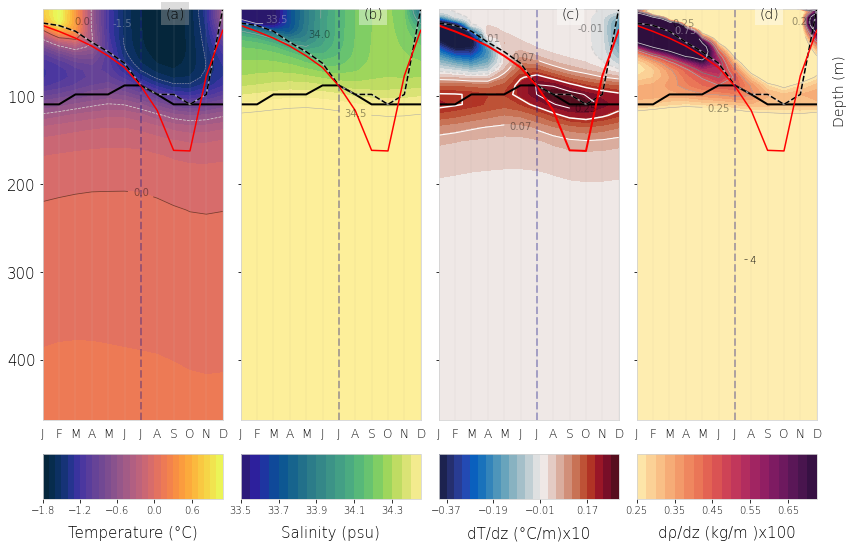

In [15]:
# Seaborn colorpalette : https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
import matplotlib
matplotlib.rc('axes',edgecolor='lightgrey') #---> Sets the color of the frame, once this is run, it set that default for everything in the session


x=list(range(12))

from matplotlib import ticker

import matplotlib.gridspec as gridspec # GRIDSPEC !
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?

fig = plt.figure(1, figsize=(15,8));


# Now, create the gridspec structure, as required
gs = gridspec.GridSpec(2,5, height_ratios=[1.1,0.12], width_ratios=[.9, .9, .9, .9, .9])  # Make it 9 rows to adjust the length of colorbar

# 3 rows, 4 columns, each with the required size ratios. 
# Also make sure the margins and spacing are apropriate

gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.1, hspace=0.15)

#################################################################################################################################

# T - Climatology

ax1 = plt.subplot(gs[0,0]) # place it where it should be.

tt = temp_climatology_plot_WL(wl_Tc, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='lightgrey', alpha=0.5, lw=0.25 ) # vertical lines

t = plt.text( 7.5, 10,   '(a)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='darkgrey', alpha=0.4, edgecolor='none'))

# Colorbar
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 
lev = lev = np.arange(-1.8,1.2,0.1) # Make sure to check this is the same level used in the temperature plot!!!!
colmap =  cm.cm.thermal  #cm.cm.thermal #'bwr'
im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')
cb.set_label('Temperature (°C)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)

#-----------------------------------------------------------------------------------------

# S - Climatology

ax1 = plt.subplot(gs[0,1]) # place it where it should be.

tt = salt_climatology_plot_WL(wl_Sc, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='grey', alpha=0.3, lw=0.25 ) # vertical lines
#ax.axes.yaxis.set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())

t = plt.text( 7.5, 10,   '(b)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='w', alpha=0.4, edgecolor='none'))

# Colorbar
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 
lev = np.arange(33.5,34.5,0.05) # Make sure to check this is the same level used in the temperature plot!!!!
colmap = cm.cm.haline  #cm.cm.matter
im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')

# while using mathematical eqtn, that have default fontweight, so we need to change that explicitly
# #########matplotlib.rcParams['text.latex.preamble'] = [r'\lightmath']

# ######params = {'mathtext.default': 'regular' }          
# ######plt.rcParams.update(params)
cb.set_label('Salinity (psu)', labelpad=10, fontsize=15, fontweight='light')
#cb.set_label('Salinity (kgm-3)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)

#-----------------------------------------------------------------------------------------

# dT/dz - Climatology

ax1 = plt.subplot(gs[0,2]) # place it where it should be.

tt = dTdz_climatology_plot_WL (wl_dTdz_1, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='grey', alpha=0.25, lw=0.25 ) # vertical lines
#ax.axes.yaxis.set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())

t = plt.text( 7.5, 10,   '(c)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='w', alpha=0.4, edgecolor='none'))

# Colorbar
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 

#colormap, levels 
mnlev = -0.4
mxlev = 0.3
nlev = 10
lev = np.arange(mnlev, mxlev, mxlev/nlev)
cont_lev = [ 0.075, 0.25]   
cont_lev2 = [-0.01]

colmap = cm.cm.balance

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=mnlev, vcenter=0., vmax=mxlev)

im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, norm=divnorm);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')

# while using mathematical eqtn, that have default fontweight, so we need to change that explicitly

cb.set_label('dT/dz (°C/m)x10', labelpad=10, fontsize=15, fontweight='light')
#cb.set_label('Salinity (kgm-3)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)


#-----------------------------------------------------------------------------------------

# dD/dz - Climatology

ax1 = plt.subplot(gs[0,3]) # place it where it should be.

tt = dDdz_climatology_plot_WL (wl_dDdz_1, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='grey', alpha=0.25, lw=0.25 ) # vertical lines
#ax.axes.yaxis.set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())

t = plt.text( 7.5, 10,   '(d)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='w', alpha=0.4, edgecolor='none'))

t = plt.text( 12, 130,   'Depth (m)',color='k', fontsize=14, fontweight='light', rotation=90)



t = plt.text( 6.57, 290,   '  4',color='k', fontsize=10, fontweight='light')
t = plt.text( 6.3, 289,   ' -',color='k', fontsize=12, fontweight='light')

#t = plt.text( 8.87, 290,   '  2',color='k', fontsize=10, fontweight='light')



# Colorbar
cbax = plt.subplot(gs[1,3]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 

lev = np.arange(0.25, 0.75, 0.025) # Make sure to check this is the same level used in the temperature plot!!!!
colmap = cm.cm.matter  #cm.cm.rain
im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')

# https://stackoverflow.com/questions/27698377/how-do-i-make-sans-serif-superscript-or-subscript-text-in-matplotlib

# while using mathematical eqtn, that have default fontweight, so we need to change that explicitly
# #########matplotlib.rcParams['text.latex.preamble'] = [r'\lightmath']

# ######params = {'mathtext.default': 'regular' }          
# ######plt.rcParams.update(params)
cb.set_label('d\u03C1/dz (kg/m )x100', labelpad=10, fontsize=15, fontweight='light')
#cb.set_label('Salinity (kgm-3)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)



#-----------------------------------------------------------------------------------------
#fig.savefig('WL_Clim_23_23.png')

# WL climatology for lat-min at -90

latmin  = -90. # TESTING 80 S

temp_monthly = OM_temp.groupby('time.month').mean('time')
#WL
print ('Calculating WL T Clim')
wl_Tc = sector_mean(temp_monthly, A, wl)
wl_Tc.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_T_test90S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_T.nc ')

salt_monthly = OM_salt.groupby('time.month').mean('time')
#WL
print ('Calculating WL S Clim')
wl_Sc = sector_mean(salt_monthly, A, wl)
wl_Sc.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_S_test90S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_S.nc ')


rho_monthly = OM_rho.groupby('time.month').mean('time')
#RS
print ('Calculating WL D Clim')
wl_Dc = sector_mean(rho_monthly, A, wl)
wl_Dc.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_D_test90S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_D.nc ')

mld_monthly = OM_mld.groupby('time.month').mean('time')
#RS
print ('Calculating WL mld Clim')
wl_mld = mld_sector_mean(mld_monthly, A, wl)
wl_mld.to_netcdf('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_mld_test90S_04012022.nc')
print ('Saved to 6_AreaWeighted_WL_Clim_mld.nc ')

### Load the calculated data from Gadi

In [10]:
# loading the data back
da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_T_test90S_04012022.nc') 
wl_Tc = da.temp

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_S_test90S_04012022.nc') 
wl_Sc = da.salt

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_D_test90S_04012022.nc') 
wl_Dc = da.pot_rho_0

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_mld_test90S_04012022.nc') 
wl_mld = da.mld

wl_dTdz = np.gradient(wl_Tc)/np.gradient(wl_Tc.st_ocean)
wl_dSdz = np.gradient(wl_Sc)/np.gradient(wl_Sc.st_ocean)
wl_dDdz = np.gradient(wl_Dc)/np.gradient(wl_Sc.st_ocean)

new_dims=wl_Tc.dims[:] 
new_coords=wl_Tc.coords

wl_dTdz_1 = xr.DataArray(wl_dTdz[1,...].squeeze(),dims=new_dims,coords=new_coords)
wl_dSdz_1 = xr.DataArray(wl_dSdz[1,...].squeeze(),dims=new_dims,coords=new_coords)
wl_dDdz_1 = xr.DataArray(wl_dDdz[1,...].squeeze(),dims=new_dims,coords=new_coords)

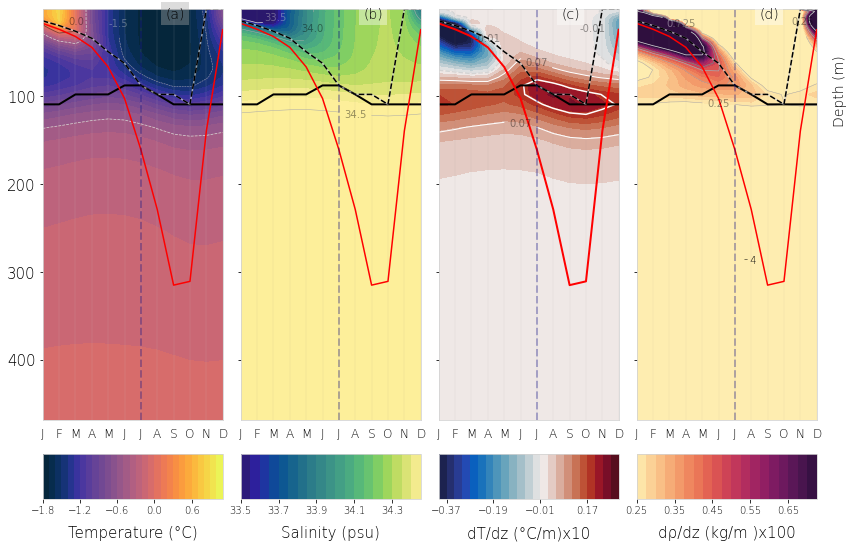

In [13]:
# Seaborn colorpalette : https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
import matplotlib
matplotlib.rc('axes',edgecolor='lightgrey') #---> Sets the color of the frame, once this is run, it set that default for everything in the session


x=list(range(12))

from matplotlib import ticker

import matplotlib.gridspec as gridspec # GRIDSPEC !
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?

fig = plt.figure(1, figsize=(15,8));


# Now, create the gridspec structure, as required
gs = gridspec.GridSpec(2,5, height_ratios=[1.1,0.12], width_ratios=[.9, .9, .9, .9, .9])  # Make it 9 rows to adjust the length of colorbar

# 3 rows, 4 columns, each with the required size ratios. 
# Also make sure the margins and spacing are apropriate

gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.1, hspace=0.15)

#################################################################################################################################

# T - Climatology

ax1 = plt.subplot(gs[0,0]) # place it where it should be.

tt = temp_climatology_plot_WL(wl_Tc, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='lightgrey', alpha=0.5, lw=0.25 ) # vertical lines

t = plt.text( 7.5, 10,   '(a)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='darkgrey', alpha=0.4, edgecolor='none'))

# Colorbar
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 
lev = lev = np.arange(-1.8,1.2,0.1) # Make sure to check this is the same level used in the temperature plot!!!!
colmap =  cm.cm.thermal  #cm.cm.thermal #'bwr'
im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')
cb.set_label('Temperature (°C)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)

#-----------------------------------------------------------------------------------------

# S - Climatology

ax1 = plt.subplot(gs[0,1]) # place it where it should be.

tt = salt_climatology_plot_WL(wl_Sc, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='grey', alpha=0.3, lw=0.25 ) # vertical lines
#ax.axes.yaxis.set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())

t = plt.text( 7.5, 10,   '(b)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='w', alpha=0.4, edgecolor='none'))

# Colorbar
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 
lev = np.arange(33.5,34.5,0.05) # Make sure to check this is the same level used in the temperature plot!!!!
colmap = cm.cm.haline  #cm.cm.matter
im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')

# while using mathematical eqtn, that have default fontweight, so we need to change that explicitly
# #########matplotlib.rcParams['text.latex.preamble'] = [r'\lightmath']

# ######params = {'mathtext.default': 'regular' }          
# ######plt.rcParams.update(params)
cb.set_label('Salinity (psu)', labelpad=10, fontsize=15, fontweight='light')
#cb.set_label('Salinity (kgm-3)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)

#-----------------------------------------------------------------------------------------

# dT/dz - Climatology

ax1 = plt.subplot(gs[0,2]) # place it where it should be.

tt = dTdz_climatology_plot_WL (wl_dTdz_1, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='grey', alpha=0.25, lw=0.25 ) # vertical lines
#ax.axes.yaxis.set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())

t = plt.text( 7.5, 10,   '(c)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='w', alpha=0.4, edgecolor='none'))

# Colorbar
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 

#colormap, levels 
mnlev = -0.4
mxlev = 0.3
nlev = 10
lev = np.arange(mnlev, mxlev, mxlev/nlev)
cont_lev = [ 0.075, 0.25]   
cont_lev2 = [-0.01]

colmap = cm.cm.balance

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=mnlev, vcenter=0., vmax=mxlev)

im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, norm=divnorm);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')

# while using mathematical eqtn, that have default fontweight, so we need to change that explicitly

cb.set_label('dT/dz (°C/m)x10', labelpad=10, fontsize=15, fontweight='light')
#cb.set_label('Salinity (kgm-3)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)


#-----------------------------------------------------------------------------------------

# dD/dz - Climatology

ax1 = plt.subplot(gs[0,3]) # place it where it should be.

tt = dDdz_climatology_plot_WL (wl_dDdz_1, wl_dTdz, wl_dDdz, wl_mld)
plt.axvline(x=6, color='navy', linestyle='--', linewidth=2, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
plt.setp(ax.get_yticklabels(), fontsize=15, fontweight='ultralight')
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='ultralight')
plt.gca().xaxis.grid(color='grey', alpha=0.25, lw=0.25 ) # vertical lines
#ax.axes.yaxis.set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())

t = plt.text( 7.5, 10,   '(d)',color='k', fontsize=14, fontweight='light')
t.set_bbox(dict(facecolor='w', alpha=0.4, edgecolor='none'))

t = plt.text( 12, 130,   'Depth (m)',color='k', fontsize=14, fontweight='light', rotation=90)



t = plt.text( 6.57, 290,   '  4',color='k', fontsize=10, fontweight='light')
t = plt.text( 6.3, 289,   ' -',color='k', fontsize=12, fontweight='light')

#t = plt.text( 8.87, 290,   '  2',color='k', fontsize=10, fontweight='light')



# Colorbar
cbax = plt.subplot(gs[1,3]) # Place it where it should be.
# # --------------------------------------------------------
data = wl_Tc 

lev = np.arange(0.25, 0.75, 0.025) # Make sure to check this is the same level used in the temperature plot!!!!
colmap = cm.cm.matter  #cm.cm.rain
im=plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False);#--> T-colorbar

cb = Colorbar(ax = cbax, mappable = im, orientation = 'horizontal')

# https://stackoverflow.com/questions/27698377/how-do-i-make-sans-serif-superscript-or-subscript-text-in-matplotlib

# while using mathematical eqtn, that have default fontweight, so we need to change that explicitly
# #########matplotlib.rcParams['text.latex.preamble'] = [r'\lightmath']

# ######params = {'mathtext.default': 'regular' }          
# ######plt.rcParams.update(params)
cb.set_label('d\u03C1/dz (kg/m )x100', labelpad=10, fontsize=15, fontweight='light')
#cb.set_label('Salinity (kgm-3)', labelpad=10, fontsize=15, fontweight='light')
plt.setp(cb.ax.xaxis.get_ticklabels(), weight='light', fontsize=10);
cb.ax.locator_params(nbins=6)



#-----------------------------------------------------------------------------------------
#fig.savefig('WL_Clim_23_23.png')

# Testing the MLD

MLD from the density climatology

In [81]:
# Calculate the MLD from model density

da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_D_test90S_04012022.nc') 
wl_Dc90 = da.pot_rho_0 

test_depth2 = (wl_Dc90.st_ocean).where(wl_Dc90 <= wl_Dc90[:,0]+0.03) # This will be using the density climatology bounded at 90S
mld_depth = test_depth2.max('st_ocean')
mld_depth.values

array([ 2.93995261,  9.44688511, 13.81592751, 22.24687195, 29.44745636,
       38.24056625, 55.20640182, 69.69342041, 78.0960083 , 78.0960083 ,
       29.44745636,  1.68073463])

In [78]:
# test = xr.where(wl_Dc90 <= wl_Dc90[:,0]+0.03, 1, np.nan)
ind = test.sum('st_ocean').values.astype(int)

In [114]:
test_ind =ind-1

In [33]:
# Loading the model MLD using 70S as boundary for comparison
da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_mld_test70S_04012022.nc') 
wl_mld70S = da.mld

# Loading the model MLD using 90S as boundary for comparison
da = xr.open_dataset('/g/data/v45/sl0603/code_and_data/T_S_climatology/6_AreaWeighted_WL_Clim_mld_test90S_04012022.nc') 
wl_mld90S = da.mld

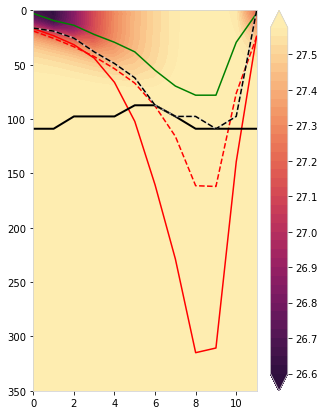

In [34]:
fig = plt.figure(figsize=(5, 7))

x = list(range(12))
data = wl_Dc90-1000
lev = np.arange(26.6, 27.6, 0.025) #(0, 3, 0.25)
colmap = cm.cm.matter_r

# Fill plot using the density climatology
p = plt.contourf(x, data.st_ocean, data.transpose(), levels=lev, cmap = colmap, yincrease=False, add_colorbar=False, extend='both') #levels=lev,


#Coparing the MLD claculated vs the model derived
plt.plot(x, mld_depth, 'green') #---> calculated mld
plt.plot(x, wl_mld90S, 'r') #----> mld from model averaged at 90S
plt.plot(x, wl_mld70S, 'r--') #----> mld from model averaged at 70S

# dT/dz
tt1 = dTdz_max_depth(wl_dTdz,  wl_Tc)
tt1 = tt1[0:12]
plt.plot(x, tt1, color='k', lw=2)

# dRho/dz
tt2 = dTdz_max_depth(wl_dDdz,  wl_Tc)
tt2 = tt2[0:12]
plt.plot(x, tt2, color='lightgrey', lw=1.5, alpha=0.7)
plt.plot(x, tt2, color='k', lw=1.5, ls='--') #'teal'



plt.ylim((0,350))
plt.gca().invert_yaxis()
plt.colorbar()

## Calculating the actual difference between the surface density and the density at the calculated MLD

In [35]:
# Get the surface density values
test_surface_values = wl_Dc90[:,0]
#test_surface_values

# Get the density at the  calculated MLD

# From the st_ocean values get the index for MLD
indx = []
for i in range (12):
    ind = np.where(wl_Dc90.st_ocean == mld_depth[i])    
    indx.append(ind)    
#indx  #--> This index is within a list and the elements are tuples containing 1x1 arrays eg. [(array[4])]

# get the value of rho at the mld 
test_mld_values_n = []
for i in range (12):
    ind = np.asscalar(np.asarray(indx[i]))
    x = wl_Dc90[i, ind]
    test_mld_values_n.append(x)    
#test_mld_values_n    

# Get the difference
diff = test_mld_values_n - test_surface_values
diff

<xarray.DataArray 'pot_rho_0' (month: 12)>
array([0.0189209 , 0.0300293 , 0.0144043 , 0.0246582 , 0.02087402,
       0.01855469, 0.02709961, 0.02661133, 0.02368164, 0.02270508,
       0.02966309, 0.03027344], dtype=float32)
Coordinates:
    st_ocean  float64 0.5413
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
mld = []
for i, j in zip(range(1,13), ind):
    mld.append(wl_Dc90.sel(month = i)[j].values.tolist())
    
mld

[1026.6732177734375,
 1026.646240234375,
 1026.8623046875,
 1027.1324462890625,
 1027.318115234375,
 1027.4423828125,
 1027.533935546875,
 1027.593017578125,
 1027.626220703125,
 1027.6334228515625,
 1027.5797119140625,
 1027.2003173828125]

In [112]:
mld - wl_Dc90[:,0]

<xarray.DataArray 'pot_rho_0' (month: 12)>
array([0.0189209 , 0.0300293 , 0.0144043 , 0.0246582 , 0.02087402,
       0.01855469, 0.02709961, 0.02661133, 0.02368164, 0.02270508,
       0.02966309, 0.02001953])
Coordinates:
    st_ocean  float64 0.5413
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12